In [163]:
# It is quite frustrating but VS code wont reload imports without these comments
%reload_ext autoreload
%autoreload 2
# You may could remove them... Not sure.

import random
from cells import *
from bp_class import *
from short_DNA_region_class import *
from chromosome_class import *
from sister_chromatids import *
from enum import Enum
import dna_functions
import sister_chromosome_functions
import cell_functions
import uuid
import save_cells
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import warnings
import mutation_functions


# This function is VERY specific to this script.   It is faster to not always make new cells and instead just 
#  "Pretend" that we made a new cell by spoofing an "old" cell as a new cell.  This means that we neeed to  update
#  all the "Parent" and id information.
def propagate_existing_cell_as_new_cell(cel):
    # Updates the parent cell to look like a new cell and adds it to the new_generation
    # TOD THis will need to be updated so it changes all the IDs etc throughout the CELL to a new id.
    # Also needs to clear the recombination events tracker in all the chromosomes
    cel_id = cel.id #The current ID that will be changed and used as the parent
    cel_new_id = uuid.uuid1() # The new id that will replace the old ID
    cel.id = cel_new_id
    cel.parent = cel_id
    for sis_chromo in cel.sister_chromatids:
        old_sis_chromo_id = sis_chromo.id
        new_sis_choma_id = uuid.uuid1()
        sis_chromo.id = new_sis_choma_id
        sis_chromo.parent = old_sis_chromo_id
        for chromo in sis_chromo.chromosomes:
            old_chromo_id = chromo.id
            new_chromo_id =uuid.uuid1()
            chromo.id = new_chromo_id
            chromo.parent = old_chromo_id
            chromo.recombination = None # Need to reset the chromosome recombination tracker
            for g in chromo.genes:
                old_g_id = g.id
                new_g_id = uuid.uuid1()
                g.id = new_g_id
                g.parent = old_g_id


    return(cel)



# TODO
1. CHANGE THE mutate and recombination protocols to accept a math function as the probability thingy
2. Incorporate the Gene conversion and Recombination stuff as discussed with Cherie
3. Think about population size management
    4. Make it so we "modify" the cells in place instead of generating new ones each time

Alright We have our librarys for developing a cell with chromosomes.   Now lets build our first cell.  This cell will need a full gambit of chromosomes!  And these chromosomes need genes, and those genes need basepairs!!

In [164]:
#first_chromo = dna_functions.make_baisc_chromosome(3000, 120)
#first_sister_chromo = sister_chromosome_functions.basic_sister_chromatids_from_chromo(first_chromo, 3)

In [165]:
cell_params = [
    {"chromo_length" : 3000, "ave_gene_length" : 120, "chromo_count" : 2},
    {"chromo_length" : 4000, "ave_gene_length" : 200, "chromo_count" : 3},
    {"chromo_length" : 1000, "ave_gene_length" : 130, "chromo_count" : 1},
    {"chromo_length" : 5000, "ave_gene_length" : 40, "chromo_count" : 6}
]
first_cell = cell_functions.create_basic_cell(cell_params, uuid.uuid1(), generation = 0)

Okay thus far we can create a cell and replicate it!  Kinda like a generation.   The cell is an exact copy of the parent cell.  There is no mutation capability yet or recombination.  However we can change the CCN of different chromosomes.    First though lets test out our cell and see if we can make a few generations and record those data in an effective way!

In [166]:
generations = 2
replications_per_generation = 8
filename = "/Users/canonmallory/Library/Mobile Documents/com~apple~CloudDocs/Documents/Local_Only.nosync/School/Briggs Lab/CCNV/Genetic Models/Testing_Logs/" + str(uuid.uuid1()) + ".csv"

## This is the function dictating the frequence of point mutations in a cell.
#  Currently the point mutations are randomly distributed across the genome.
mutation_params = {'mean': 5}
mutation_function = mutation_functions.poisson



# TODO The likely hood of two chromosomes recombining is not currently dependent on 
#  CCN of those chromosomes.  It is equal across all sister-chromatids
# RECOMBINATION
    # There are two typse of Reombination that can occur in this version of the model.
recombination_params = {
    "recombination_probability": [3, .5] # The normal curve about mean that variation will happen
}

ccnv_params = {
    "variation_probability": [0, 5], # The normal curve about mean that variation will happen
    "probability_of_pos": 0.5 #likelyhood any change will be positive (inverse for neg)
}

nominal_max_generation_size = 600 # Arbitrary number of max cells in eacy generation

#Mean and Std Deviation for the number of cells will die each generation
# As a percentage of the total number of cells
strain_death_rate_mean_percentage = 0.2

metadata = {
    "mutation_function": mutation_function.__name__,
    "mutation_params": mutation_params,
    "max_generation_size": nominal_max_generation_size,
    "death_rate_percent": strain_death_rate_mean_percentage,
    "date": datetime.date.today(),
    "recombination_probability_mean": recombination_params["recombination_probability"][0],
    "recombination_probability_stdev": recombination_params["recombination_probability"][1],
    "ccnv_probability_mean": ccnv_params["variation_probability"][0],
    "ccnv_probability_mean": ccnv_params["variation_probability"][1],
    "ccnv_probability_of_increase": ccnv_params["probability_of_pos"]
}

#Debugging values for evaulating simulation speed
total_print_elapsed_time = []
total_generation_make_elapsed_time = []

current_generation = [first_cell]
total_cells = len(current_generation)
cell_growth = [len(current_generation)]
generation_size = [len(current_generation)]
#Must write the first generation down (fence post problem)
#save_cells.write_generation_to_csv(current_generation, filename, metadata)

# Lets make a master DF and write the first generation to that DF
all_generations = pd.DataFrame(columns = save_cells.std_headers)
all_generations = save_cells.write_generation_to_df(all_generations, current_generation)

# Lets also go ahead and create the CSV file that we will use.   Best to do it now incase that gets an error
save_cells.write_new_file_with_metadata(filename, metadata)




for  i in tqdm(range(generations)):

    # This incorperates cell death at some random constant rate
    #if i != 0:
    #    number_cells_to_die = round(len(current_generation) * strain_death_rate_mean_percentage)
    #    #print("Number of Cells Death: " + str(number_cells_to_die))
    #    cells_to_die = random.sample(current_generation, number_cells_to_die)
    #    for cell_to_die in cells_to_die:
    #        current_generation.remove(cell_to_die)


    # This is to manage the cells size.  It will grow exponentially foreveer unless
    # We cap it at some value.   In reality this should probably forllow a sigmoidal 
    # Growth function based on density or something like that...  For now though we will
    # just keep it to a sorta consistant size
    if len(current_generation)*replications_per_generation >= nominal_max_generation_size:
        replications_per_generation = 1#round(nominal_max_generation_size/len(current_generation))

    #print("Number of reps per generation: " + str(replications_per_generation))




    new_generation = []
    
    # This is the start of the slow step
    # To help speed it up slightly, Each parent cell will be reused in the second new generation
    #       It will go through mutations etc like all the other cells and it's ID and Parent will
    #       updated to make it look just like an new cell.  This will prevent making a bunch of new
    #       objects each time which should speed up this process.  Be careful when modifying this
    #       since it could easy mess up results if done incorrectly!
    # if replications is set to zero then this whole step should be skipped...  Should never be zero
    generation_make_start_time = datetime.datetime.now()
    if replications_per_generation > 0:
        #This removes 1 because 1 of the new cells will be the modified parent cell
        num_new_cels = replications_per_generation - 1

        for cel in current_generation:
            #This has to happen first since re get the cell ID from the parent cell
            new_cels = cell_functions.multiple_duplicates_with_UUID(cel, num_new_cels)
            new_generation += new_cels

            # This will spoof the old cell as a new cell.  THis will hopefully speed up the generation process
            new_generation += [propagate_existing_cell_as_new_cell(cel)]
    else:
        warnings.warn("replications_per_generation is not > 0 which is unlikely")
    
    if len(new_generation) < 0.5 * len(current_generation):
        warnings.warn("The new generation is half the old generation.  This is not likely")

    # THis measures the elapsed time for creating the new generation for debugging info    
    generation_make_end_time = datetime.datetime.now()
    generation_elapsed_time = generation_make_end_time - generation_make_start_time
    total_generation_make_elapsed_time.append(generation_elapsed_time)
    #This is the end of the slow step


    #========================================================================#
    # THis is where we will mutate/recombinate/CCNV the new generation!
    
    #Does NOTHING right now.
    cell_functions.recombinate_cells_norm(new_generation, recombination_params)

    # TODO
    #  Need to think on this.   I have the normal about zero.  Such that neg
    # numbers are equally as likely as positive numbers.  Negs are considered teh same
    #  as positive (e.g. abs(nrom))   THis makes a change twice as likely....
    cell_functions.ccnv_cels_norm(new_generation, ccnv_params)



    #This randomly point mutates cells at some cell rate determined by the "function"
    # Currently this does not account for the genome size at all.  Constitant cell RATE TODO
    cell_functions.randomly_distributed_point_mutate_cells(new_generation, mutation_function, mutation_params)
    #========================================================================#

    # THis is when we stop and save the new generation!
    # Time to save is measured for debugging purposes
    # I have the data saved to a CSV at the end of every generation.  This is mostly so that if the simulation crashes
    #      we will preserve the generations up to the crash.   It does use a pandas DF within the safe function.
    #      but this pandas DF is deleted each "Generation Loop".   Although this is likely slower than just having a massice
    #      dataframe I like it better because of the progress save.
    print_start_time = datetime.datetime.now()
    #save_cells.write_generation_to_csv(new_generation, filename) #This version took really long :(
    all_generations = save_cells.write_generation_to_df(all_generations, new_generation)
    print_end_time = datetime.datetime.now()
    print_elapsed_time = print_end_time - print_start_time
    total_print_elapsed_time.append(print_elapsed_time)


    total_cells += len(new_generation)
    cell_growth.append(total_cells) # For figure later showing the population sizes
    generation_size.append(len(new_generation))
    current_generation = new_generation

#We now have a massive DF with all the data.   We best save this somewhere
all_generations.to_csv(filename, mode='a', header=False, index=False)

print("Complete")


Created file '/Users/canonmallory/Library/Mobile Documents/com~apple~CloudDocs/Documents/Local_Only.nosync/School/Briggs Lab/CCNV/Genetic Models/Testing_Logs/17dfd67e-1170-11ef-b312-acde48001122.csv'


  0%|          | 0/2 [00:00<?, ?it/s]/Users/canonmallory/Library/Mobile Documents/com~apple~CloudDocs/Documents/School/UCSB/Briggs Lab/CCNV/Genetics_Models/Genetic_Model/Python_Agent_Model/sister_chromosome_functions.py:96: UserWarning: recombination_even_not_possible
  warnings.warn("recombination_even_not_possible")
100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


Complete


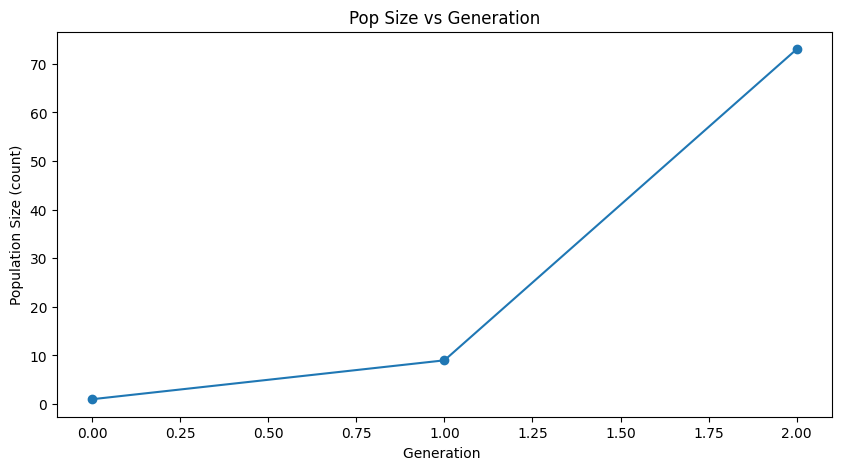

In [167]:
# Lets create a graph of the generations!

generations = range(len(cell_growth))
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(generations, cell_growth, marker='o')  # Plot x and y using a line plot with markers

# Adding labels and title
plt.xlabel('Generation ')
plt.ylabel('Population Size (count)')
plt.title('Pop Size vs Generation')

# Show the plot
plt.show()

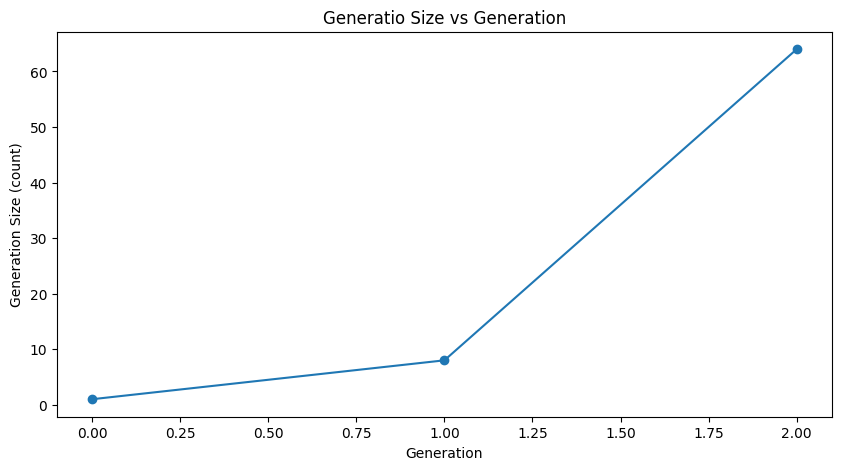

In [168]:
generations = range(len(generation_size))
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(generations, generation_size, marker='o', label="Generation Size")  # Plot x and y using a line plot with markers

# Adding labels and title
plt.xlabel('Generation')
plt.ylabel('Generation Size (count)')
plt.title('Generatio Size vs Generation')

# Show the plot
plt.show()

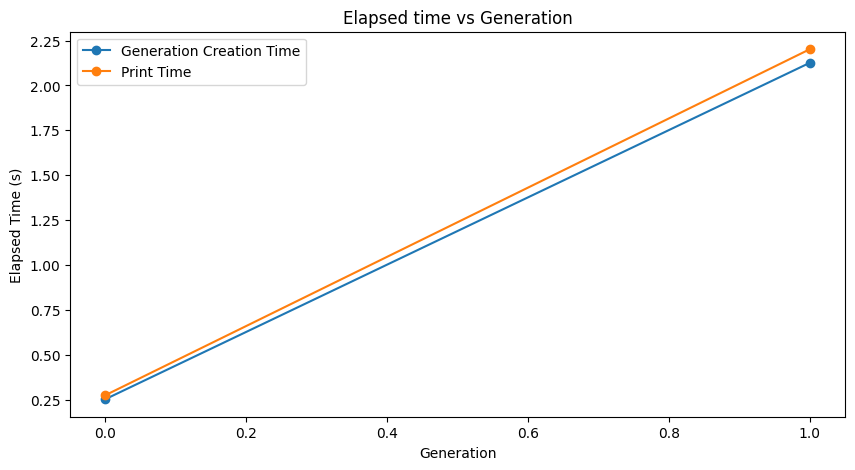

In [169]:
generations = range(len(generation_size)-1)
generations_s = [t.total_seconds() for t in total_generation_make_elapsed_time]
print_s = [t.total_seconds() for t in total_print_elapsed_time]
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(generations, generations_s, marker='o', label='Generation Creation Time')  # Plot x and y using a line plot with markers
plt.plot(generations, print_s, marker='o', label="Print Time")  # Plot x and y using a line plot with markers
# Adding labels and title
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Elapsed Time (s)')
plt.title('Elapsed time vs Generation')

# Show the plot
plt.show()

m = total_generation_make_elapsed_time[1]


In [170]:
m = total_generation_make_elapsed_time[1]
print(m.total_seconds())

2.125835


Make the production rate be a decreasing density of the number of cells.   What is a common density dependance?

In [171]:
cell_params = [
    {"chromo_length" : 50, "ave_gene_length" : 5, "chromo_count" : 2}
]
testing_cell = cell_functions.create_basic_cell(cell_params, uuid.uuid1())


#cell_functions.recombinate_random_chromatid(first_cell)

In [172]:
testing_cell.sequence_str()
print(testing_cell)
print(testing_cell.sister_chromatids)
print(testing_cell.sister_chromatids[0].chromosomes)
print(testing_cell.sister_chromatids[0].chromosomes[0].genes)
print(testing_cell.sister_chromatids[0].chromosomes[0].genes[0].sequence)

[<chromosome_class.chromosome object at 0x1325bc8b0>, <chromosome_class.chromosome object at 0x130e6cdc0>]
[<short_DNA_region_class.gene object at 0x15105ca60>, <short_DNA_region_class.gene object at 0x12dfb1160>, <short_DNA_region_class.gene object at 0x12773bf70>, <short_DNA_region_class.gene object at 0x12773bfa0>, <short_DNA_region_class.gene object at 0x12773bf40>, <short_DNA_region_class.gene object at 0x12773bf10>, <short_DNA_region_class.gene object at 0x1325bce80>, <short_DNA_region_class.gene object at 0x1325bc940>, <short_DNA_region_class.gene object at 0x1325bcd90>]
[<Bp.t: 1>, <Bp.g: 3>, <Bp.t: 1>, <Bp.g: 3>, <Bp.g: 3>]


In [173]:
#testing_cell.sister_chromatids[0].chromosomes[0].genes[0] = gene([Bp('a'), Bp('a'), Bp('a')])
#testing_cell.sequence_str()

In [174]:
#print(testing_cell.sister_chromatids[0].chromosomes)
print(testing_cell.sister_chromatids[0].chromosomes)
cell_functions.recombinate_random_chromatid(testing_cell)
#testing_cell.sequence_str()



[<chromosome_class.chromosome object at 0x1325bc8b0>, <chromosome_class.chromosome object at 0x130e6cdc0>]


In [175]:
testing_cell.sister_chromatids[0].chromosomes
